In [37]:
# generate a nn agent for a communication game, there should be a fixed number of meanings and words and the two agents should interact to communicate 
# about these meanings 

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
import numpy as np
import random
# from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import math

# set random seed for reproducibility
random.seed(42)

# torch.manual_seed(42)

In [2]:
class Agent:
    def __init__(self, n_meanings, n_signals, alpha=0.1, decay=0.0, epsilon=0.05):
        """
        Steels (1995)-style agent with reinforcement learning and lateral inhibition.

        Parameters
        ----------
        n_meanings : int
            Number of possible meanings (concepts).
        n_signals : int
            Number of possible signals (forms).
        alpha : float
            Learning rate (strength of updates, e.g. 0.1).
        decay : float
            Global forgetting rate per interaction (e.g. 0.01).
        epsilon : float
            Exploration probability (chance to pick a random signal).
        """
        self.n_meanings = n_meanings
        self.n_signals = n_signals
        self.alpha = alpha
        self.decay = decay
        self.epsilon = epsilon

        # Initialize lexicon: meaning × signal → weight
        self.lexicon = {
            m: {s: 0.1 for s in range(n_signals)}
            for m in range(n_meanings)
        }

    # === SPEAKER ===
    def getSignal(self, meaning):
        """
        Choose a signal for a given meaning.
        - Mostly picks based on learned weights.
        - Occasionally explores a random signal (epsilon).
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.n_signals - 1)

        weights = self.lexicon[meaning]
        total = sum(weights.values())

        if total == 0:
            return random.randint(0, self.n_signals - 1)

        signals, probs = zip(*[(s, w / total) for s, w in weights.items()])
        return random.choices(signals, probs)[0]

    # === HEARER ===
    def guessMeaning(self, sigma):
        """
        Guess which meaning a signal refers to, based on weights.
        """
        scores = [self.lexicon[m].get(sigma, 0) for m in range(self.n_meanings)]
        total = sum(scores)
        if total == 0:
            return random.randint(0, self.n_meanings - 1)

        probs = [s / total for s in scores]
        return random.choices(range(self.n_meanings), probs)[0]

    # === LEARNING ===
    def update(self, outcome, meaning, sigma, guess):
        """
        Update association strengths after an interaction.

        Implements:
        - Reinforcement for successful mappings.
        - Lateral inhibition to promote one-to-one mappings.
        - Weakening for unsuccessful ones.
        - Optional global decay.
        """
        # Global decay (forgetting)
        if self.decay > 0:
            for m in range(self.n_meanings):
                for s in range(self.n_signals):
                    self.lexicon[m][s] *= (1 - self.decay)

        if outcome:  # success
            # Reinforce the successful meaning-signal mapping
            self.lexicon[meaning][sigma] += self.alpha * (1 - self.lexicon[meaning][sigma])

            # Lateral inhibition: competing signals for same meaning
            for s in self.lexicon[meaning]:
                if s != sigma:
                    self.lexicon[meaning][s] *= (1 - self.alpha)

            # Lateral inhibition: same signal for other meanings
            for m in range(self.n_meanings):
                if m != meaning:
                    self.lexicon[m][sigma] *= (1 - self.alpha)

        else:  # failure
            # Weaken this specific mapping
            self.lexicon[meaning][sigma] *= (1 - self.alpha)

    def __repr__(self):
        return f"<Agent n_meanings={self.n_meanings} n_signals={self.n_signals}>"


In [3]:
def simulate_rounds(n_rounds=100, 
                    n_meanings=3, 
                    n_signals=5, 
                    alpha=0.1, # learning rate
                    decay=0.0, # forgetting rate
                    epsilon=0.05): # exploration rate
    df = pd.DataFrame(columns=["round", "meaning", "signal", "guess", "outcome"])

    A = Agent(n_meanings, 
              n_signals, 
              alpha, 
              decay, 
              epsilon)
    B = Agent(n_meanings, 
              n_signals,
              alpha, 
              decay, 
              epsilon)

    for t in range(1, n_rounds + 1):
        meaning = random.randint(0, n_meanings - 1)
        sigma = A.getSignal(meaning)
        guess = B.guessMeaning(sigma)
        outcome = int(guess == meaning)

        # Update both agents
        A.update(outcome, meaning, sigma, guess)
        B.update(outcome, meaning, sigma, guess)

        print(f"Round {t:2d}: meaning={meaning}, sigma={sigma}, "
              f"guess={guess}, outcome={outcome}")
        df = pd.concat([df, pd.DataFrame({"round": [t], "meaning": [meaning], 
                                          "signal": [sigma], "guess": [guess], 
                                          "outcome": [outcome]})], ignore_index=True)
    return df

In [101]:
num_agents = 100
n_meanings = 5
n_signals = 5
n_rounds = 200
skew = 1.3 # 1 = uniform, >1 = skewed toward early pairs

agents = [Agent(n_meanings=n_meanings, n_signals=n_signals) for _ in range(num_agents)]
pairs = [(i, j) for i in range(num_agents) for j in range(i + 1, num_agents)]

# --- Step 1: deterministic weights based on rank ---
ranks = np.arange(1, len(pairs) + 1)
if skew == 1:
    weights = np.ones_like(ranks, dtype=float)
else:
    weights = (1 / ranks) ** (skew - 1)  # decreasing deterministically

# normalize and scale to get number of rounds
weights /= weights.max()  # max = 1
pair_rounds = {pair: int(round(w * n_rounds)) for pair, w in zip(pairs, weights)}

# ensure at least 1 round per pair
for pair in pair_rounds:
    pair_rounds[pair] = max(1, pair_rounds[pair])

print("Interaction allocation per pair:")
for pair, n_int in pair_rounds.items():
    print(f"{pair}: {n_int} rounds")

# --- Step 2: create interaction slots deterministically ---
interaction_list = []
for pair, n_int in pair_rounds.items():
    i, j = pair
    for r in range(1, n_int + 1):
        interaction_list.append((i, j, r))

# --- Step 3: shuffle order to mix pairs ---
random.shuffle(interaction_list)

# --- Step 4: run interactions ---
records = []

for i, j, r in interaction_list:
    if r % 2 == 0:
        sender, receiver = agents[i], agents[j]
    else:
        sender, receiver = agents[j], agents[i]
    pair_label = f"{i}:{j}"

    meaning = random.randint(0, n_meanings - 1)
    signal = sender.getSignal(meaning)
    guess = receiver.guessMeaning(signal)
    outcome = int(guess == meaning)

    sender.update(outcome, meaning, signal, guess)
    receiver.update(outcome, meaning, signal, guess)

    records.append({
        "round": r,
        "meaning": meaning,
        "signal": signal,
        "guess": guess,
        "outcome": outcome,
        "pair": pair_label
    })

df = pd.DataFrame(records)
print(df.tail())

Interaction allocation per pair:
(0, 1): 200 rounds
(0, 2): 162 rounds
(0, 3): 144 rounds
(0, 4): 132 rounds
(0, 5): 123 rounds
(0, 6): 117 rounds
(0, 7): 112 rounds
(0, 8): 107 rounds
(0, 9): 103 rounds
(0, 10): 100 rounds
(0, 11): 97 rounds
(0, 12): 95 rounds
(0, 13): 93 rounds
(0, 14): 91 rounds
(0, 15): 89 rounds
(0, 16): 87 rounds
(0, 17): 85 rounds
(0, 18): 84 rounds
(0, 19): 83 rounds
(0, 20): 81 rounds
(0, 21): 80 rounds
(0, 22): 79 rounds
(0, 23): 78 rounds
(0, 24): 77 rounds
(0, 25): 76 rounds
(0, 26): 75 rounds
(0, 27): 74 rounds
(0, 28): 74 rounds
(0, 29): 73 rounds
(0, 30): 72 rounds
(0, 31): 71 rounds
(0, 32): 71 rounds
(0, 33): 70 rounds
(0, 34): 69 rounds
(0, 35): 69 rounds
(0, 36): 68 rounds
(0, 37): 68 rounds
(0, 38): 67 rounds
(0, 39): 67 rounds
(0, 40): 66 rounds
(0, 41): 66 rounds
(0, 42): 65 rounds
(0, 43): 65 rounds
(0, 44): 64 rounds
(0, 45): 64 rounds
(0, 46): 63 rounds
(0, 47): 63 rounds
(0, 48): 63 rounds
(0, 49): 62 rounds
(0, 50): 62 rounds
(0, 51): 61 roun

In [102]:
# number of interactions per pair
interactions_per_pair = df['pair'].value_counts()
interactions_per_pair

pair
0:1      200
0:2      162
0:3      144
0:4      132
0:5      123
        ... 
86:94     16
65:77     16
62:99     16
69:94     16
87:92     16
Name: count, Length: 4950, dtype: int64

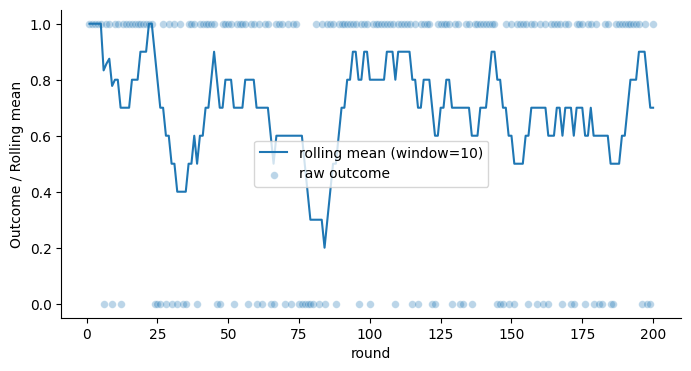

In [103]:
# plot jiust one diad
df_pair = df[df["pair"] == "0:1"]
plt.figure(figsize=(8, 4))
window = 10

df_pair = df_pair.copy()
df_pair['round'] = df_pair['round'].astype(int)
df_pair = df_pair.sort_values('round')
df_pair['outcome'] = pd.to_numeric(df_pair['outcome'])
df_pair['rolling_mean'] = df_pair['outcome'].rolling(window=window, min_periods=1).mean()

sns.lineplot(data=df_pair, x='round', y='rolling_mean', label=f'rolling mean (window={window})')
sns.scatterplot(data=df_pair, x='round', y='outcome', alpha=0.3, s=30, label='raw outcome')
plt.ylabel('Outcome / Rolling mean')
plt.legend()
sns.despine()
plt.show()

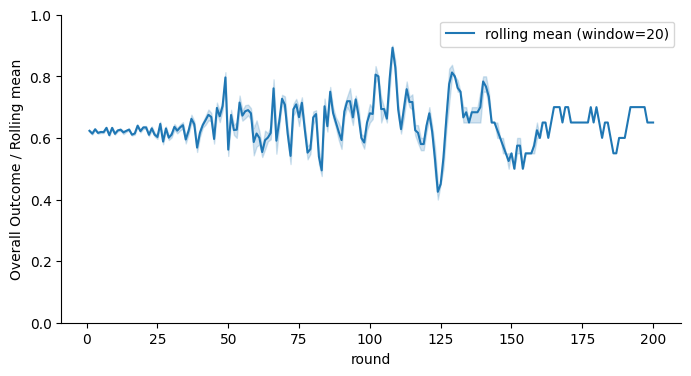

In [104]:
# plot overall performance
plt.figure(figsize=(8, 4))
window = 20
df = df.copy()
df['round'] = df['round'].astype(int)
df = df.sort_values('round')
df['outcome'] = pd.to_numeric(df['outcome'])
df['rolling_mean'] = df['outcome'].rolling(window=window, min_periods=1).mean()
sns.lineplot(data=df, x='round', y='rolling_mean', label=f'rolling mean (window={window})')
plt.ylabel('Overall Outcome / Rolling mean')
plt.legend()
sns.despine()
plt.ylim(0, 1)
plt.show()

In [105]:
# # plot individual trajectories for all pairs
# plt.figure(figsize=(8, 4))
# window = 20
# for pair_id, df_pair in df.groupby("pair"):
#     df_pair = df_pair.copy()
#     df_pair['round'] = df_pair['round'].astype(int)
#     df_pair = df_pair.sort_values('round')
#     df_pair['outcome'] = pd.to_numeric(df_pair['outcome'])
#     df_pair['rolling_mean'] = df_pair['outcome'].rolling(window=window).mean()

#     sns.lineplot(data=df_pair, x='round', y='rolling_mean', 
#                  alpha=0.3, color='black')
# plt.ylabel('Rolling Mean Outcome')
# plt.title(f'Individual Interaction Trajectories (window={window})')
# plt.ylim(0, 1)
# plt.show()

In [106]:
# plot number of interactions per individual agent
interaction_counts = df['pair'].value_counts().reset_index()
interaction_counts.columns = ['pair', 'count']
agent_counts = {}
for _, row in interaction_counts.iterrows():    
    agents_in_pair = row['pair'].split(':')
    for agent in agents_in_pair:
        agent_counts[agent] = agent_counts.get(agent, 0) + row['count']

agent_counts_df = pd.DataFrame.from_dict(agent_counts, orient='index', columns=['interaction_count'])
agent_counts_df.index.name = 'agent'
agent_counts_df = agent_counts_df.reset_index()

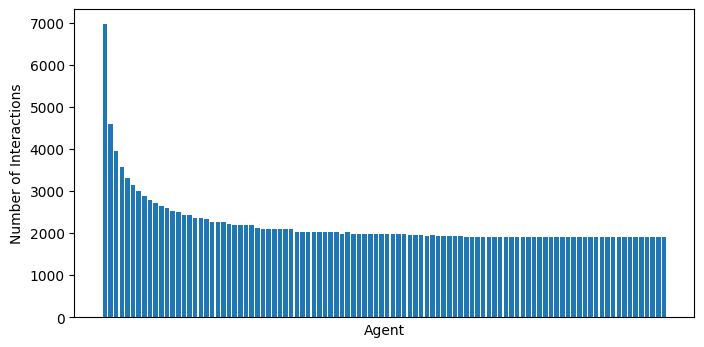

In [107]:
plt.figure(figsize=(8, 4))
plt.bar(agent_counts_df['agent'], agent_counts_df['interaction_count'])
plt.xticks([])
plt.xlabel('Agent')
plt.ylabel('Number of Interactions')
plt.show()

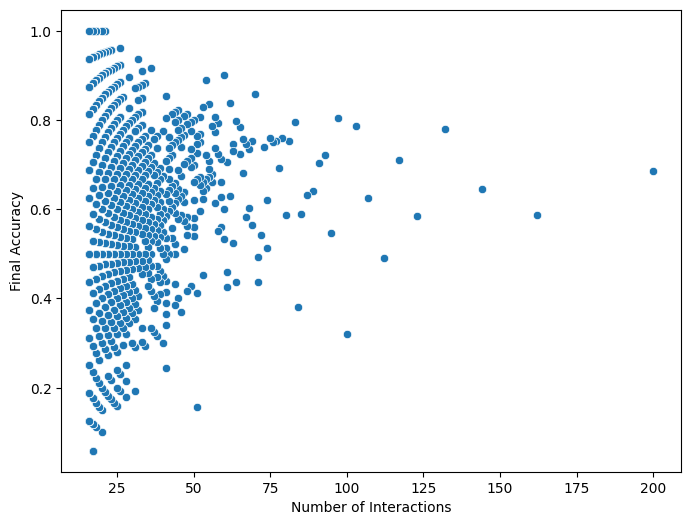

In [112]:
# plot correlation between number of interactions and performance
final_performance = df.groupby('pair')['outcome'].mean().reset_index()
final_performance.columns = ['pair', 'final_accuracy']
merged_df = pd.merge(interaction_counts, final_performance, on='pair')
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='count', y='final_accuracy')
# merged_df['interaction_group'] = (merged_df['count'] // 10) * 10
# sns.lineplot(data=merged_df, x='interaction_group', y='final_accuracy', marker='o', linestyle='')
plt.xlabel('Number of Interactions')
plt.ylabel('Final Accuracy')
plt.show()